t‑SNE: нелинейное вложение, оптимизирует дивергенцию Кульбака–Лейблера между распределениями близостей точек, хорошо показывает локальные кластеры, но медленно, плохо сохраняет глобальные расстояния, чувствительно к perplexity и random_state.

UMAP: основан на теории многобразий и топологии, строит взвешенный граф соседей и оптимизирует кросс‑энтропию; быстрее t‑SNE, лучше сохраняет глобальную структуру, более устойчив к малым изменениям параметров (n_neighbors, min_dist).

TriMAP: ориентирован на сохранение глобальной структуры через тройки точек (anchor, сосед, далёкий), улучшает глобальное расположение кластеров при сохранении локальной структуры.

PaCMAP: управляет соотношением близких, средних и далёких пар, чтобы одновременно хорошо держать локальные кластеры и общую форму; показывает хорошие результаты на омикс‑данных и эмбеддингах.

PHATE: использует диффузионные процессы и потенциал для визуализации непрерывных траекторий (например, дифференцировка клеток), хорошо показывает как кластеры, так и переходы между ними.



In [46]:
# %pip install umap-learn trimap pacmap phate scikit-learn seaborn

In [47]:
import pandas as pd


path = "drug.csv"  # замените на свой путь
df = pd.read_csv(path)
df.head()
numeric_cols = [c for c,dt in zip(df.columns,df.dtypes) if 'float' in str(dt)]
y = df['Label'].to_numpy()
df = df[numeric_cols]
df.describe()

,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,...,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,VSA_EState10,VSA_EState8,VSA_EState9
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,2.145058,805.967508,19.685075,15.659142,16.107367,12.853417,9.127392,9.525583,7.308517,7.740133,...,12.482633,8.782567,34.283900,32.673600,0.546308,3.401850,94.140083,0.886433,5.591383,60.619842
std,0.778106,443.927519,7.660753,6.308209,6.407406,5.096673,3.834029,3.917699,3.441829,3.498956,...,10.673986,11.314477,25.249751,24.182413,1.823539,9.362349,62.841882,2.693681,13.576413,28.371688
min,0.837000,2.000000,2.000000,0.908000,0.908000,1.000000,0.204000,0.204000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.368000,0.000000,10.395000
25%,1.675500,556.210750,15.267000,12.633750,12.853000,10.237000,7.363000,7.685750,5.608250,5.891250,...,4.795000,0.000000,12.842000,15.383500,0.000000,0.000000,52.600000,0.000000,0.000000,41.510750
50%,1.946000,740.543500,18.629500,15.223500,15.568000,12.194500,8.814000,9.257500,7.084500,7.282500,...,11.215000,5.867500,30.035000,30.332000,0.000000,0.000000,77.595000,0.000000,0.000000,52.457500
75%,2.353750,985.427000,23.656750,18.120000,18.533500,14.867000,10.832750,11.087750,8.987000,9.533750,...,17.768000,11.836000,46.539500,47.602000,0.000000,0.000000,124.290000,0.000000,1.418000,75.703000
max,5.079000,2629.395000,48.141000,41.328000,41.328000,32.350000,23.269000,23.269000,18.816000,18.816000,...,54.070000,40.927000,113.860000,133.460000,10.045000,77.608000,314.830000,12.007000,74.513000,151.417000


In [48]:
from sklearn.preprocessing import StandardScaler
# scaler = RobustScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

Функции для DR и оценки разделения

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances

from sklearn.manifold import TSNE
import umap
import trimap
import pacmap
import phate

Text(0.5, 1.0, 'Density distribution')

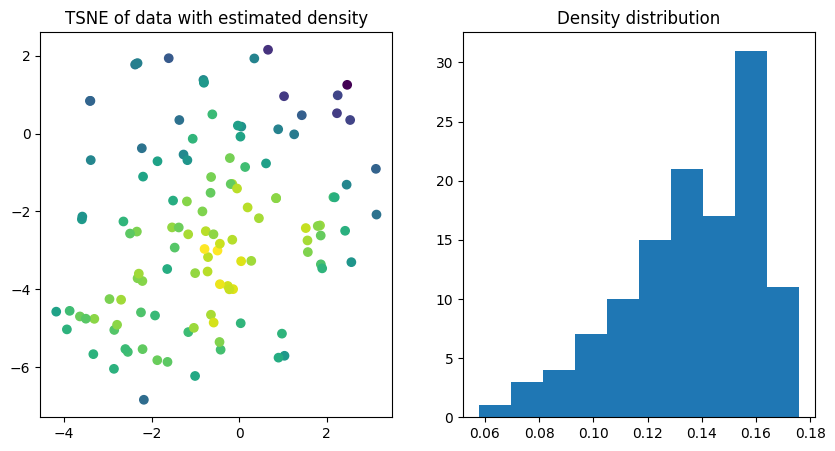

In [50]:
from knnkde import KNNKDE

knnkde = KNNKDE(k_neighbors=15,sigma=10)
probs = knnkde.fit_transform(X_scaled)
X_2d = TSNE(random_state=32,perplexity=50).fit_transform(X_scaled)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(X_2d[:,0],X_2d[:,1],c=probs)
plt.title("TSNE of data with estimated density")
plt.subplot(1,2,2)
plt.hist(probs)
plt.title("Density distribution")

In [ ]:
n_components=2
def run_tsne(X, random_state=42, perplexity=30, learning_rate=200, n_iter=1000):
    tsne = TSNE(
        n_components=n_components,
        random_state=random_state,
        perplexity=perplexity,
        learning_rate=learning_rate,
        max_iter=n_iter
    )
    return tsne.fit_transform(X)

def run_umap(X, random_state=42, n_neighbors=15, min_dist=0.1):
    _umap = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        random_state=random_state,
        min_dist=min_dist
    )
    return _umap.fit_transform(X)

def run_trimap(X, random_state=42, n_inliers=30, n_outliers=5):
    tri = trimap.TRIMAP(
        n_dims=n_components,
        n_inliers=n_inliers,
        n_outliers=n_outliers,
        # random_state=random_state
    )
    return tri.fit_transform(X)

def run_pacmap(X, random_state=42, n_neighbors=30):
    pac = pacmap.PaCMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        random_state=random_state
    )
    return pac.fit_transform(X)

def run_phate(X, random_state=42, knn=15):
    ph = phate.PHATE(
        n_components=n_components,
        knn=knn,
        random_state=random_state
    )
    return ph.fit_transform(X)

Функция оценки качества разделения

In [52]:
def separation_score(X_2d, y):
    D = pairwise_distances(X_2d)
    same = D[y[:, None] == y[None, :]]
    diff = D[y[:, None] != y[None, :]]
    return same.mean(), diff.mean(), diff.mean() / same.mean()

In [53]:
# Отрисовка

def plot_embedding(X_2d, y, title):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=X_2d[:, 0],
        y=X_2d[:, 1],
        # hue=y,
        c=probs,
        palette="tab10",
        s=30,
        legend="full"
    )
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    # plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


/home/vlad/Programs/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Calculating PHATE...
  Running PHATE on 120 observations and 83 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 0.02 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...


/home/vlad/Programs/venv/lib/python3.12/site-packages/graphtools/graphs.py:803: RuntimeWarning: Detected zero distance between samples 20 and 79. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    SGD-MDS may not have converged: stress changed by -23.4% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 0.09 seconds.
Calculated PHATE in 0.14 seconds.


/tmp/ipykernel_349113/2151901117.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


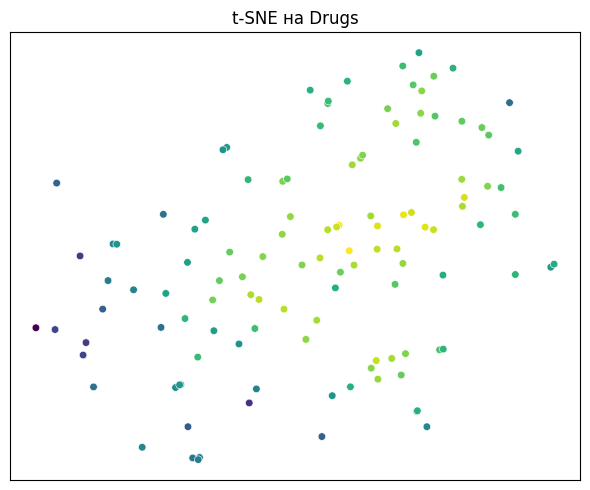

t-SNE: внутрикласс.=7.519, межкласс.=7.181, ratio=0.955


/tmp/ipykernel_349113/2151901117.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


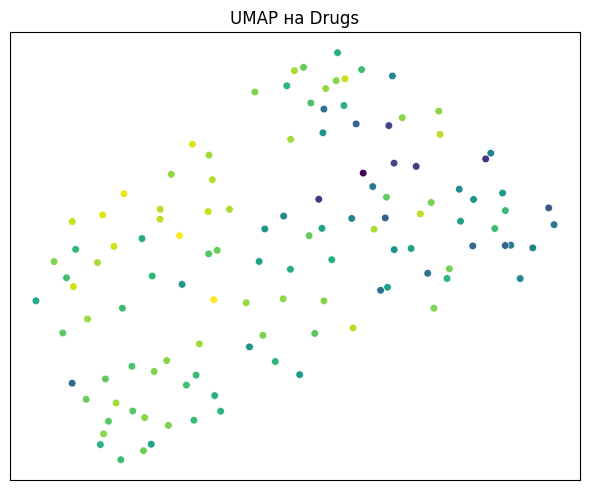

UMAP: внутрикласс.=2.255, межкласс.=2.252, ratio=0.999


/tmp/ipykernel_349113/2151901117.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


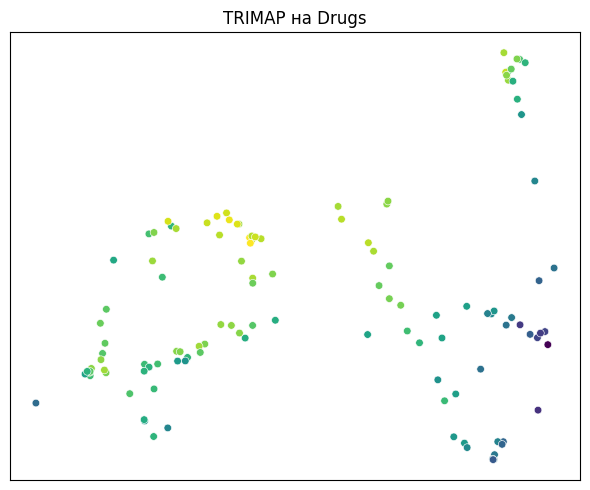

TRIMAP: внутрикласс.=38.749, межкласс.=37.279, ratio=0.962


/tmp/ipykernel_349113/2151901117.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


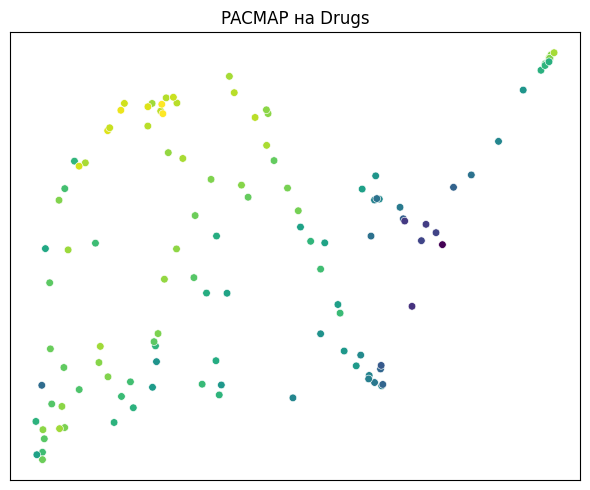

PACMAP: внутрикласс.=5.595, межкласс.=5.300, ratio=0.947


/tmp/ipykernel_349113/2151901117.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


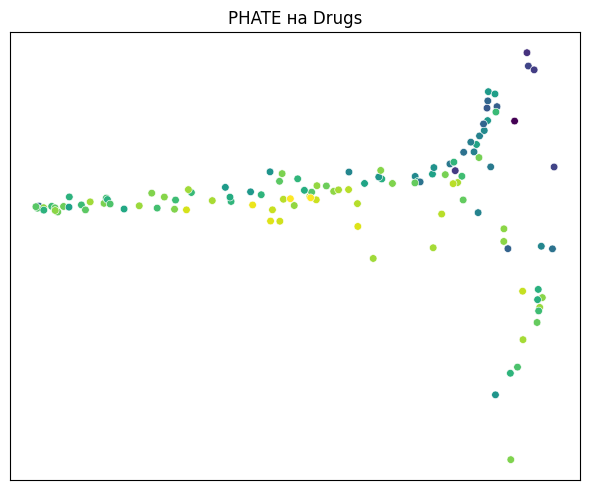

PHATE: внутрикласс.=0.103, межкласс.=0.104, ratio=1.015


In [54]:
X_list = []
names = []

X_tsne = run_tsne(X_scaled, random_state=42)
X_list.append(X_tsne); names.append("t-SNE")

X_umap = run_umap(X_scaled, random_state=42)
X_list.append(X_umap); names.append("UMAP")

"TriMAP"
X_trimap = run_trimap(X_scaled, random_state=42)
X_list.append(X_trimap); names.append("TRIMAP")


"PaCMAP"
X_pac = run_pacmap(X_scaled, random_state=42)
X_list.append(X_pac); names.append("PACMAP")

"PHATE"
X_phate = run_phate(X_scaled, random_state=42)
X_list.append(X_phate); names.append("PHATE")

for X_emb, name in zip(X_list, names):
    plot_embedding(X_emb, y, f"{name} на Drugs")
    same, diff, ratio = separation_score(X_emb, y)
    print(
        f"{name}: внутрикласс.={same:.3f}, межкласс.={diff:.3f}, ratio={ratio:.3f}"
    )


Сравнение устойчивости

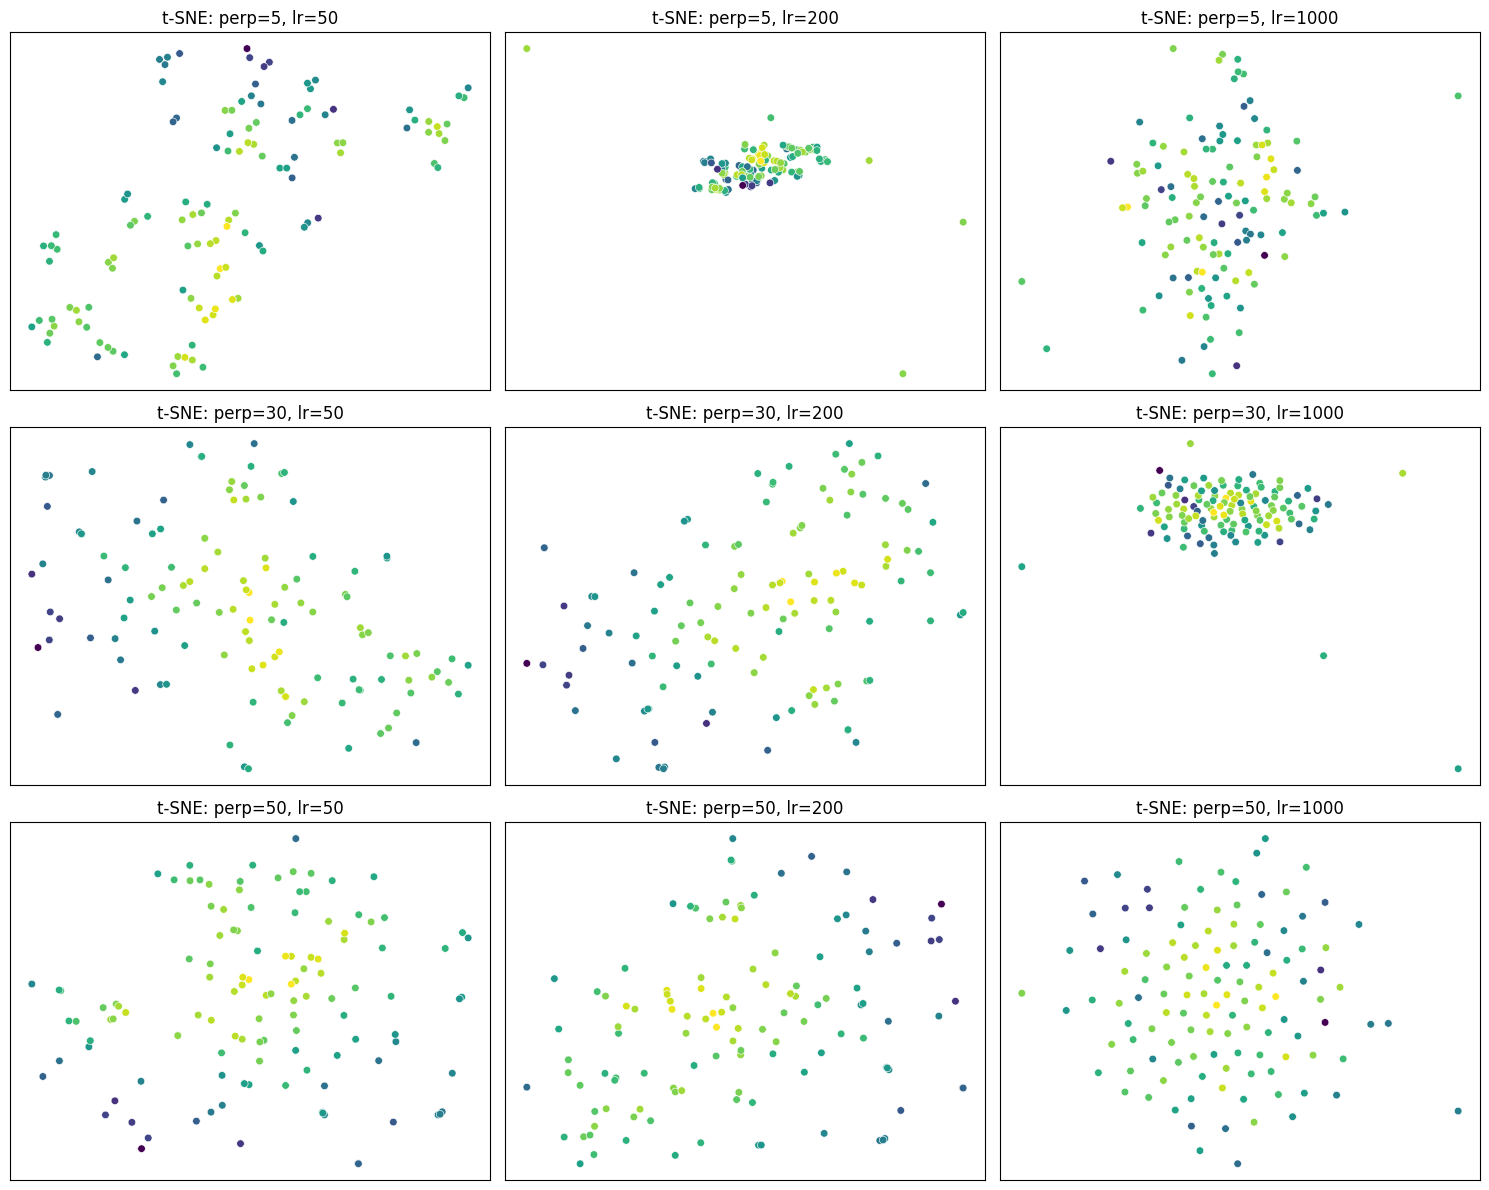

In [55]:
perplexities = [5, 30, 50]
lrs = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(lrs), figsize=(5*len(lrs), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(lrs):
        X_emb = run_tsne(X_scaled, random_state=42, perplexity=perp, learning_rate=lr)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], c=probs, s=30, ax=ax, legend=False)
        ax.set_title(f"t-SNE: perp={perp}, lr={lr}")
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


Нужно описать, как меняется форма и расположение кластеров при разных perplexity и learning_rate и что визуализация t‑SNE может сильно меняться.

/home/vlad/Programs/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_349113/2559409558.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/home/vlad/Programs/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_349113/2559409558.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/home/vlad/Programs/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_349113/2559409558.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/home/vlad/Programs/venv/lib/python3.12/site-package

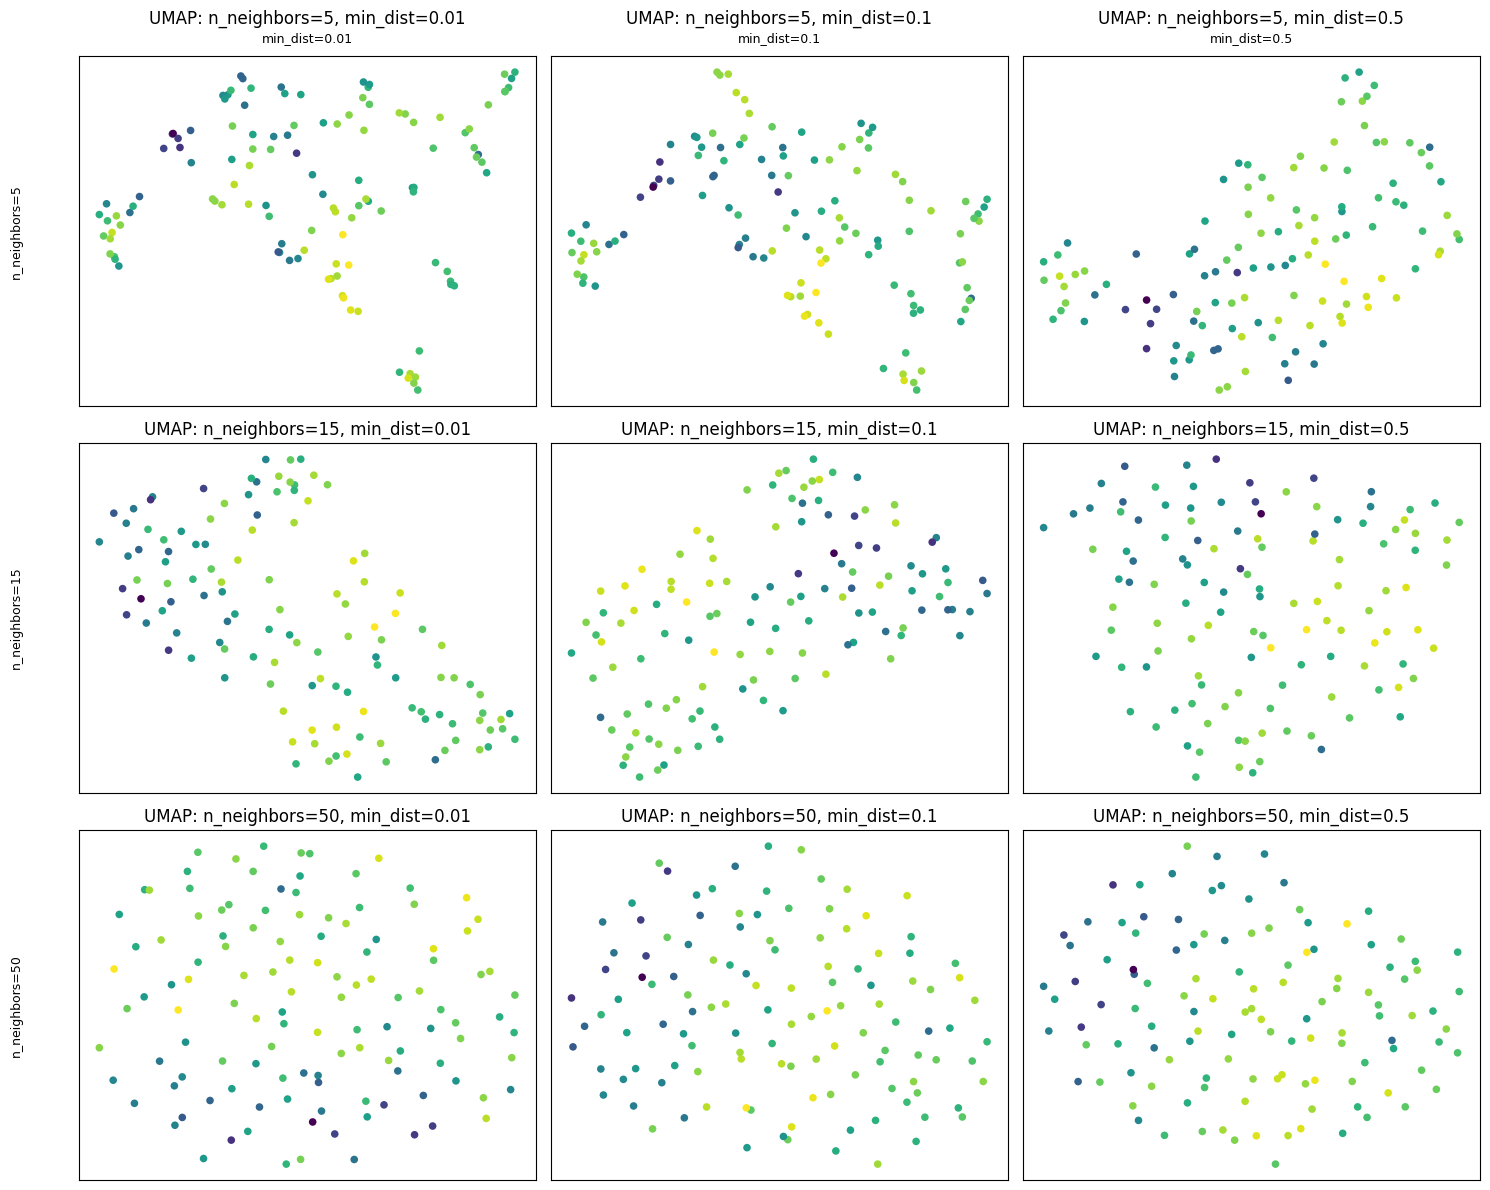

In [56]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# UMAP parameter grid (conceptual analogs to t-SNE's perplexity & learning_rate)
n_neighbors_list = [5, 15, 50]      # Controls local vs global structure (like perplexity)
min_dist_list = [0.01, 0.1, 0.5]    # Controls cluster tightness (spacing effect)

fig, axes = plt.subplots(
    len(n_neighbors_list), 
    len(min_dist_list), 
    figsize=(5 * len(min_dist_list), 4 * len(n_neighbors_list)),
    squeeze=False  # Ensure axes is always 2D array
)

for i, n_neighbors in enumerate(n_neighbors_list):
    for j, min_dist in enumerate(min_dist_list):
        # Run UMAP with current parameters
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=2,
            random_state=42,
            metric='euclidean'
        )
        X_emb = reducer.fit_transform(X_scaled)
        
        # Plot
        ax = axes[i, j]
        sns.scatterplot(
            x=X_emb[:, 0], 
            y=X_emb[:, 1], 
            c=probs, 
            s=30, 
            ax=ax, 
            legend=False,
            edgecolor='none'
        )
        ax.set_title(f"UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Optional: Add contour to highlight cluster separation at different min_dist values
        if i == 0:  # Top row labels
            ax.set_xlabel(f"min_dist={min_dist}", fontsize=9, labelpad=10)
            ax.xaxis.set_label_position('top')
        if j == 0:  # Left column labels
            ax.set_ylabel(f"n_neighbors={n_neighbors}", fontsize=9, rotation=90, labelpad=40)

plt.tight_layout()
plt.show()

Обычно структура UMAP меняется плавнее, кластеры остаются узнаваемыми при разумном диапазоне параметров.

*Задача* Аналогично нужно сделать по одной строке графиков для TriMAP, PaCMAP, PHATE с варьированием ключевого параметра (количество соседей или похожий гиперпараметр) и показать, насколько устойчив рисунок.



| Метод  | Скорость на больших данных                   | Локальное разделение              | Глобальная структура                            | Чувствительность к параметрам                         | Комментарий                                        |
| ------ | -------------------------------------------- | --------------------------------- | ----------------------------------------------- | ----------------------------------------------------- | -------------------------------------------------- |
| t‑SNE  | Низкая l                    | Отличное                   | Слабая                                   | Высокая (perplexity, lr, random_state) aicompetence+2 | Хорошо для локальных кластеров, тяжёлый тюнинг     |
| UMAP   | Высокая l                   | Очень хорошее   | Лучшая, чем у t‑SNE           | Ниже, чем у t‑SNE aicompetence+2                      | Хороший баланс локал/глобал, удобен в практике     |
| TriMAP | Средняя                              | Хорошее                   | Сильный упор на глобальную структуру    | Умеренная                                     | Лучше показывает относительное положение кластеров |
| PaCMAP | Средняя                               | Отличное                   | Хорошее                                  | Умеренная                                      | Часто даёт чёткие кластеры и форму многобразия     |
| PHATE  | Средняя/низкая (зависит от размера)   | Хорошее        | Очень хорошее, особенно для траекторий   | Умеренная                          | Сильный метод для непрерывных переходов            |

# Варианты препроцессинга
*Задача* — явно сравнить, как UMAP и t‑SNE реагируют на разные варианты нормировки и отбора признаков.

## Определяем три сценария
Без масштабирования (сырой набор признаков).

StandardScaler (z‑нормировка).

MinMaxScaler + отбор признаков по дисперсии (эмуляция feature selection).

Задание. Проделать все три сценария. Обучить все модели при разных сценария кластеризации. 
Нужно в результате:
1. описать, какие признаки были отброшены и почему это может влиять на качество кластеризации во вложенном пространстве.
1. сравнить вычислительное время и сделать вывод о масштабируемости методов
1. изменить гиперпараметры (perplexity, n_neighbors, min_dist) и исследовать совместное влияние гиперпараметров и препроцессинга на структуру кластеров.


    SGD-MDS may not have converged: stress changed by 8.4% in final iterations. Consider increasing n_iter or adjusting learning_rate.


/home/vlad/Programs/venv/lib/python3.12/site-packages/graphtools/graphs.py:803: RuntimeWarning: Detected zero distance between samples 20 and 79. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/vlad/Programs/venv/lib/python3.12/site-packages/graphtools/graphs.py:803: RuntimeWarning: Detected zero distance between samples 20 and 79. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/vlad/Programs/venv/lib/python3.12/site-packages/graphtools/graphs.py:803: RuntimeWarning: Detected zero distance between samples 20 and 79. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    SGD-MDS may not have converged: stress changed by -9.0% in final iterations. Consider increasing n_iter or adjusting learning_rate.
    SGD-MDS may not have converged: stress changed by -7.0% in final iterations. Consider increasing n_iter or adjusting learning_rate.
    SGD-MDS may not have converged: stress changed by -2.4% in final iterations. Consider increasing n_iter or adjusting learning_rate.


/home/vlad/Programs/venv/lib/python3.12/site-packages/graphtools/graphs.py:803: RuntimeWarning: Detected zero distance between samples 20 and 79. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/vlad/Programs/venv/lib/python3.12/site-packages/graphtools/graphs.py:803: RuntimeWarning: Detected zero distance between samples 20 and 79. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/vlad/Programs/venv/lib/python3.12/site-packages/graphtools/graphs.py:803: RuntimeWarning: Detected zero distance between samples 20 and 79. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    SGD-MDS may not have converged: stress changed by -23.4% in final iterations. Consider increasing n_iter or adjusting learning_rate.
    SGD-MDS may not have converged: stress changed by -1.6% in final iterations. Consider increasing n_iter or adjusting learning_rate.
    SGD-MDS may not have converged: stress changed by -14.4% in final iterations. Consider increasing n_iter or adjusting learning_rate.


/home/vlad/Programs/venv/lib/python3.12/site-packages/graphtools/graphs.py:803: RuntimeWarning: Detected zero distance between samples 20 and 79. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/vlad/Programs/venv/lib/python3.12/site-packages/graphtools/graphs.py:803: RuntimeWarning: Detected zero distance between samples 20 and 79. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/vlad/Programs/venv/lib/python3.12/site-packages/graphtools/graphs.py:803: RuntimeWarning: Detected zero distance between samples 20 and 79. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    SGD-MDS may not have converged: stress changed by -14.4% in final iterations. Consider increasing n_iter or adjusting learning_rate.


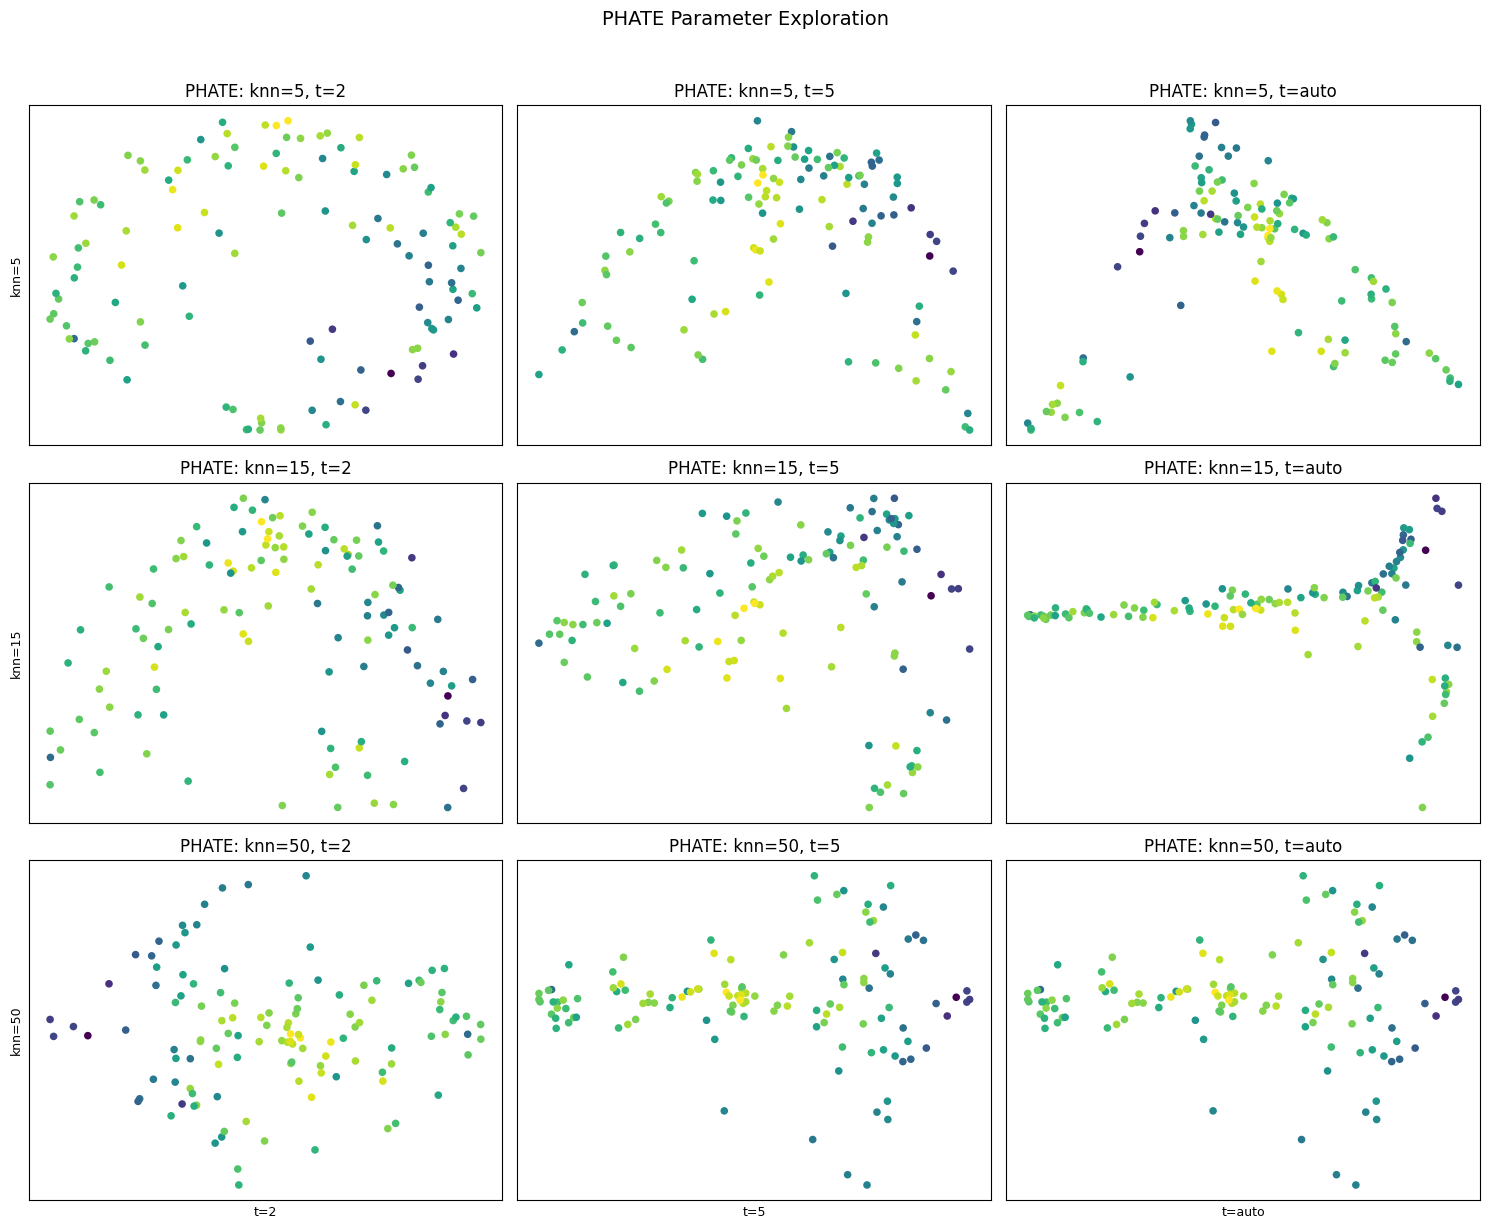

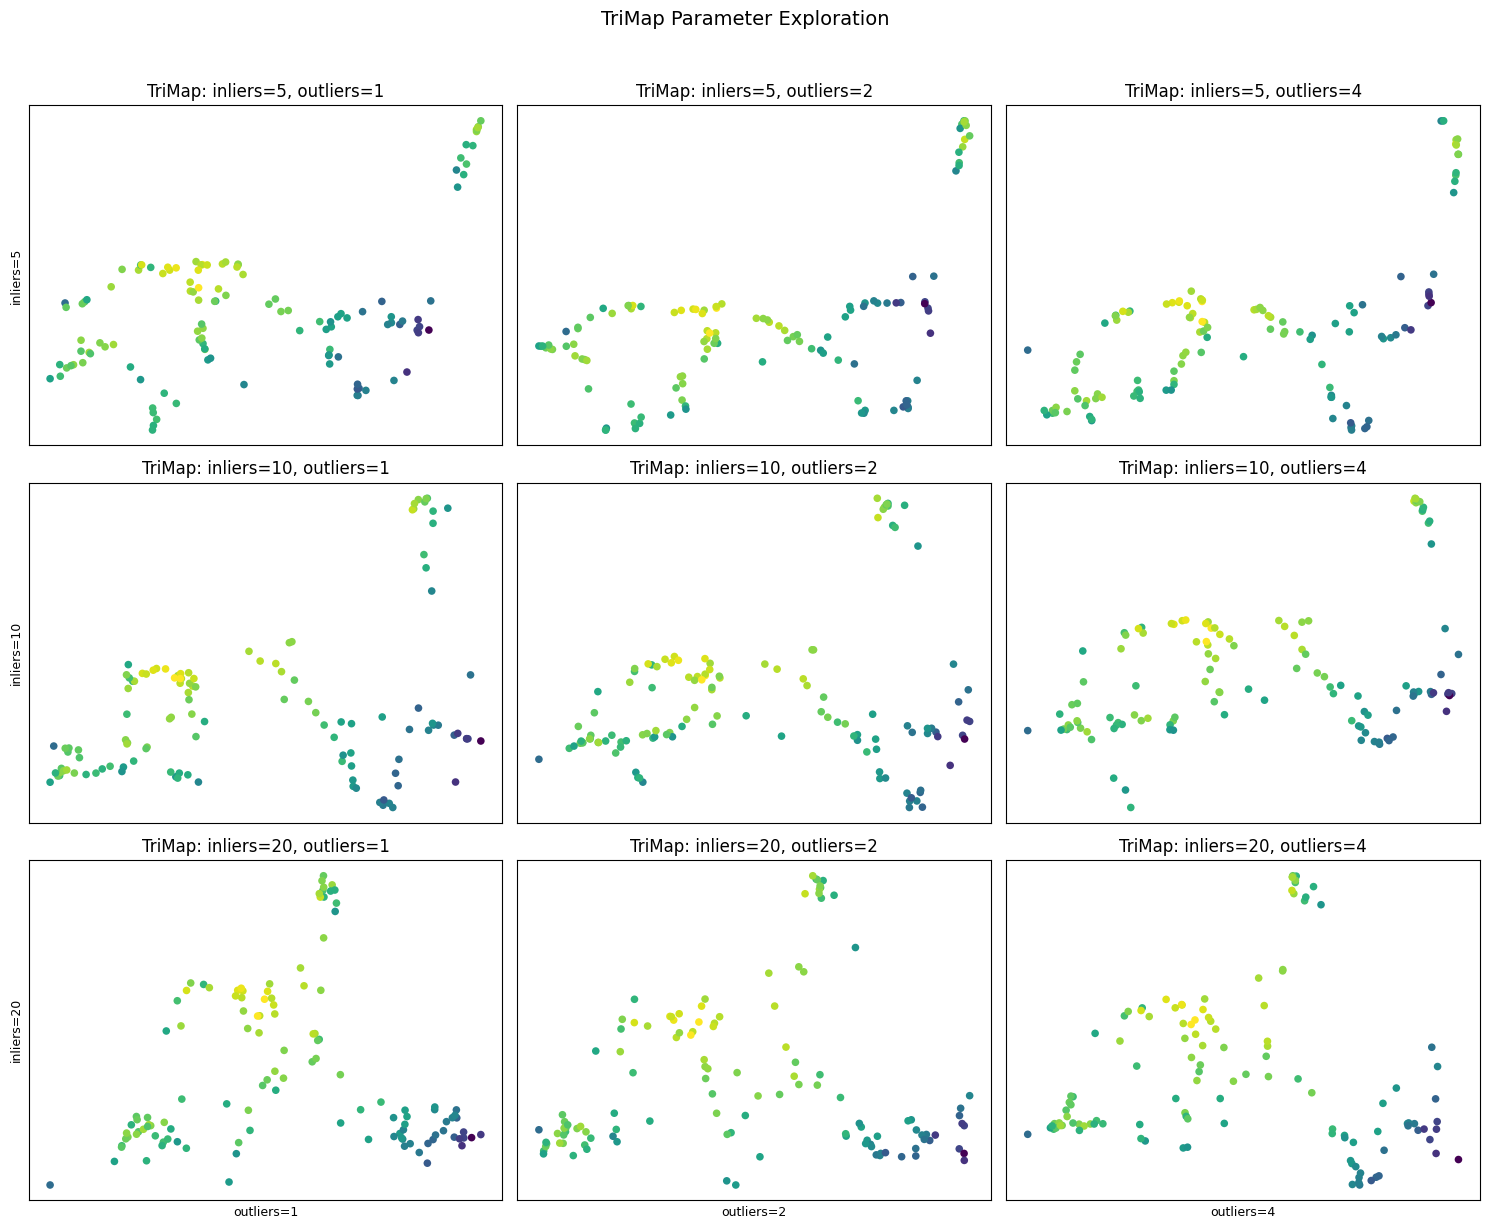

Sample size cannot accommodate number of further pairs requested. n_FP will be reduced.


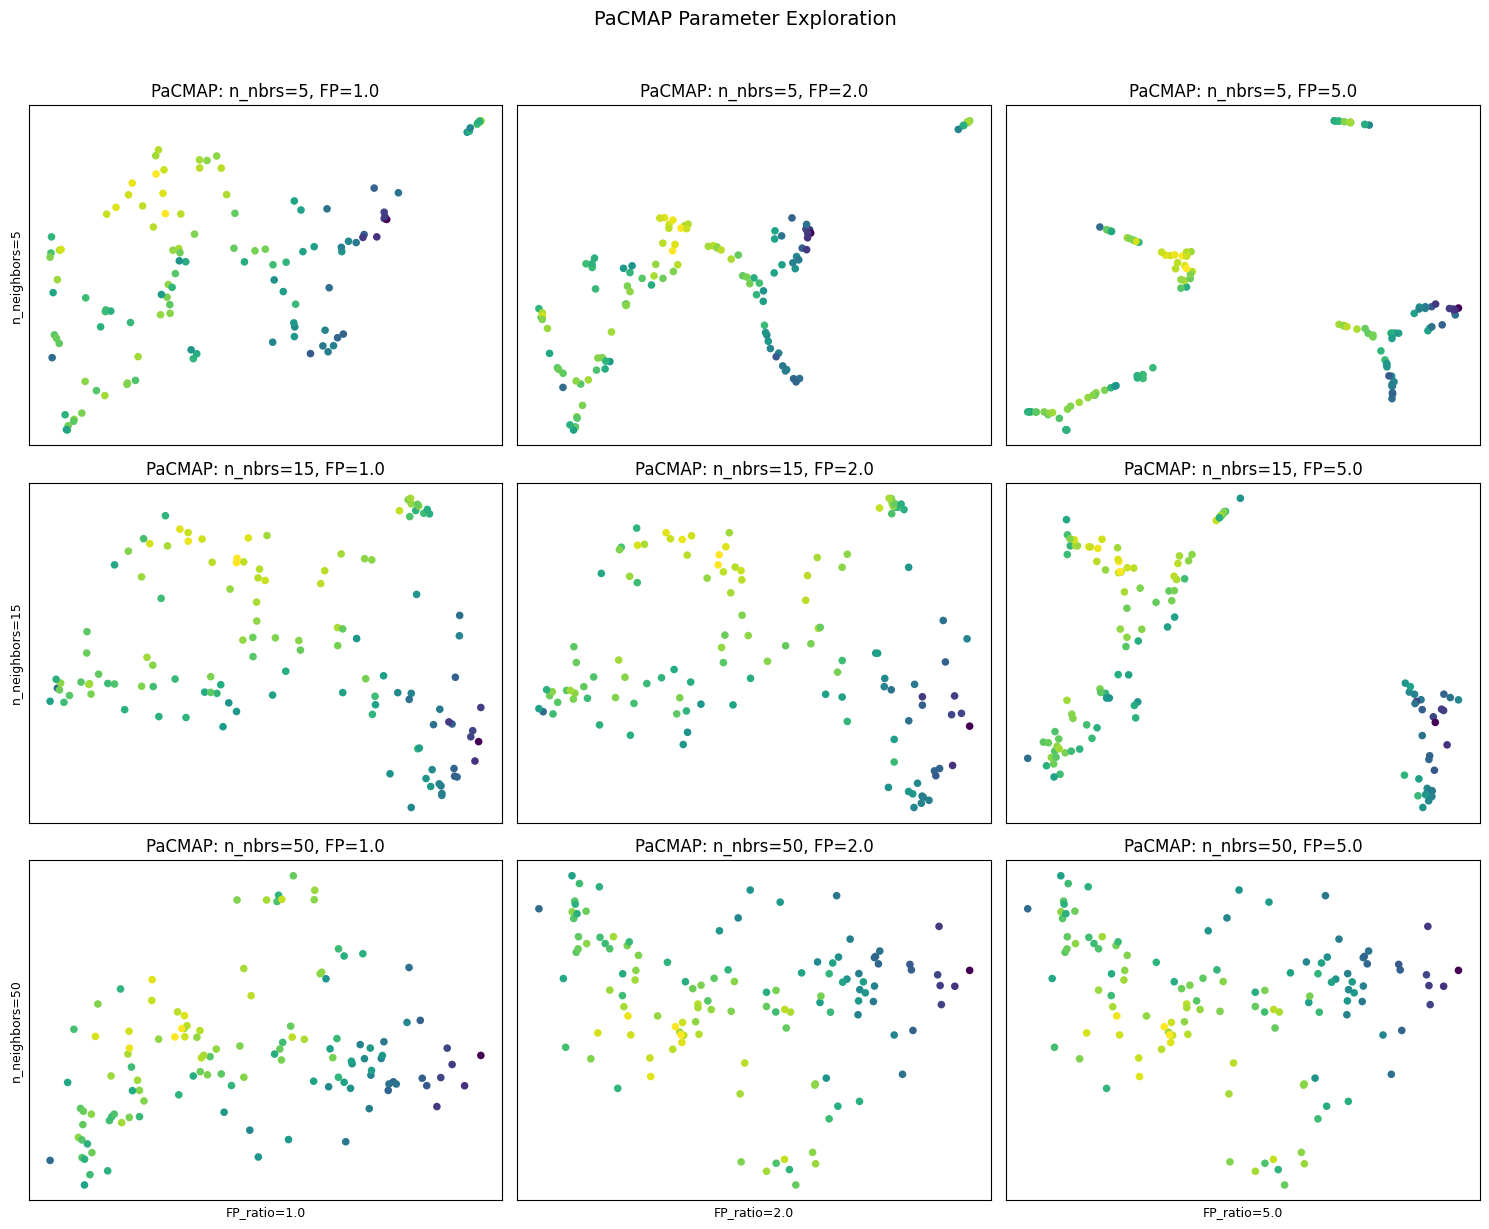

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- PHATE: knn (local structure) vs t (diffusion time) ---
import phate

knn_list = [5, 15, 50]          # Controls neighborhood size (like perplexity)
t_list = [2, 5, 'auto']         # Diffusion time: small=tight clusters, large=global structure

fig, axes = plt.subplots(
    len(knn_list), len(t_list), 
    figsize=(5 * len(t_list), 4 * len(knn_list)),
    squeeze=False
)

for i, knn in enumerate(knn_list):
    for j, t_val in enumerate(t_list):
        # Handle 'auto' diffusion time
        phate_op = phate.PHATE(
            n_components=2,
            knn=knn,
            t=t_val,
            random_state=42,
            verbose=False
        )
        X_emb = phate_op.fit_transform(X_scaled)
        
        ax = axes[i, j]
        sns.scatterplot(
            x=X_emb[:, 0], y=X_emb[:, 1], 
            c=probs, s=30, 
            ax=ax, legend=False, edgecolor='none'
        )
        ax.set_title(f"PHATE: knn={knn}, t={t_val}")
        ax.set_xticks([]); ax.set_yticks([])
        
        # Add axis labels for first row/column
        if i == len(knn_list) - 1:
            ax.set_xlabel(f"t={t_val}", fontsize=9)
        if j == 0:
            ax.set_ylabel(f"knn={knn}", fontsize=9, rotation=90)

plt.suptitle("PHATE Parameter Exploration", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# --- TriMap: n_inliers (local fidelity) vs n_outliers (global structure) ---
import trimap

inliers_list = [5, 10, 20]      # More inliers = stronger local structure preservation
outliers_list = [1, 2, 4]       # More outliers = better global structure

fig, axes = plt.subplots(
    len(inliers_list), len(outliers_list), 
    figsize=(5 * len(outliers_list), 4 * len(inliers_list)),
    squeeze=False
)

for i, n_in in enumerate(inliers_list):
    for j, n_out in enumerate(outliers_list):
        trimap_op = trimap.TRIMAP(
            n_inliers=n_in,
            n_outliers=n_out,
            n_random=5,  # Fixed reasonable value
        )
        X_emb = trimap_op.fit_transform(X_scaled)
        
        ax = axes[i, j]
        sns.scatterplot(
            x=X_emb[:, 0], y=X_emb[:, 1], 
            c=probs, s=30, 
            ax=ax, legend=False, edgecolor='none'
        )
        ax.set_title(f"TriMap: inliers={n_in}, outliers={n_out}")
        ax.set_xticks([]); ax.set_yticks([])
        
        if i == len(inliers_list) - 1:
            ax.set_xlabel(f"outliers={n_out}", fontsize=9)
        if j == 0:
            ax.set_ylabel(f"inliers={n_in}", fontsize=9, rotation=90)

plt.suptitle("TriMap Parameter Exploration", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# --- PaCMAP: n_neighbors (local scale) vs FP_ratio (far pair weighting) ---
import pacmap

neighbors_list = [5, 15, 50]    # Similar to UMAP/t-SNE perplexity
fp_ratio_list = [1.0, 2.0, 5.0] # Higher = more emphasis on global structure

fig, axes = plt.subplots(
    len(neighbors_list), len(fp_ratio_list), 
    figsize=(5 * len(fp_ratio_list), 4 * len(neighbors_list)),
    squeeze=False
)

for i, n_nbrs in enumerate(neighbors_list):
    for j, fp_ratio in enumerate(fp_ratio_list):
        pacmap_op = pacmap.PaCMAP(
            n_components=2,
            n_neighbors=n_nbrs,
            MN_ratio=0.5,      # Keep mid-near ratio fixed (default)
            FP_ratio=fp_ratio,
            random_state=42
        )
        X_emb = pacmap_op.fit_transform(X_scaled)
        
        ax = axes[i, j]
        sns.scatterplot(
            x=X_emb[:, 0], y=X_emb[:, 1], 
            c=probs, s=30, 
            ax=ax, legend=False, edgecolor='none'
        )
        ax.set_title(f"PaCMAP: n_nbrs={n_nbrs}, FP={fp_ratio}")
        ax.set_xticks([]); ax.set_yticks([])
        
        if i == len(neighbors_list) - 1:
            ax.set_xlabel(f"FP_ratio={fp_ratio}", fontsize=9)
        if j == 0:
            ax.set_ylabel(f"n_neighbors={n_nbrs}", fontsize=9, rotation=90)

plt.suptitle("PaCMAP Parameter Exploration", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()